In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import folium
from folium.plugins import HeatMap
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv("pune_rapido_1500.csv")
print(df.head())

print(df.info())

print(df.isnull().sum())


   ride_id pickup_location drop_location  distance_km  expected_time_min  \
0        1        Hadapsar        Pimpri        10.44                 31   
1        2         Kothrud         Wakad        10.61                 33   
2        3   Koregaon Park        Pimpri        13.32                 39   
3        4    Shivajinagar      Swargate        10.28                 28   
4        5     Viman Nagar         Wakad        20.63                 60   

   actual_time_min weather traffic_level vehicle_type  delay_minutes  delayed  
0               40   Clear          High         Auto              9        1  
1               44   Rainy        Medium         Bike             11        1  
2               39   Clear           Low         Auto              0        0  
3               39   Rainy          High         Auto             11        1  
4               70   Foggy        Medium         Auto             10        1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries,

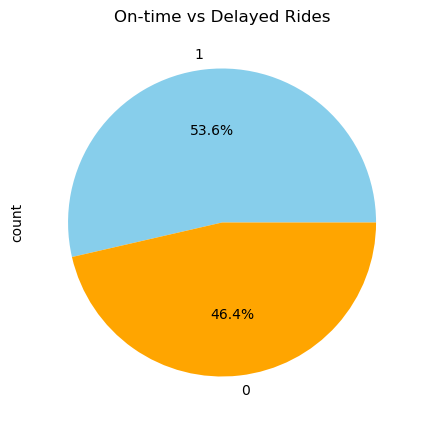

In [21]:
delay_counts = df['delayed'].value_counts()
plt.figure(figsize=(5,5))
delay_counts.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue','orange'])
plt.title("On-time vs Delayed Rides")
plt.show()


In [19]:
print(df.columns.tolist())


['ride_id', 'pickup_location', 'drop_location', 'distance_km', 'expected_time_min', 'actual_time_min', 'weather', 'traffic_level', 'vehicle_type', 'delay_minutes', 'delayed']


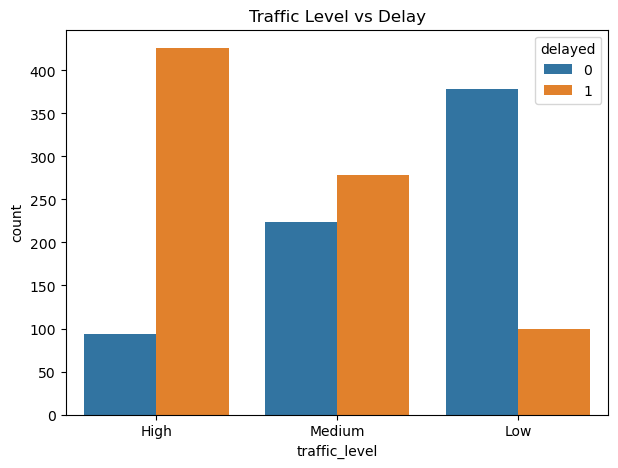

In [35]:
plt.figure(figsize=(7,5))
sns.countplot(x="traffic_level", hue="delayed", data=df)
plt.title("Traffic Level vs Delay")
plt.show()



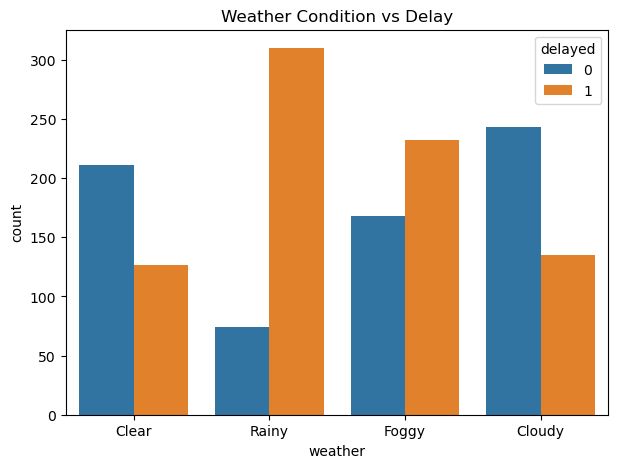

In [37]:
plt.figure(figsize=(7,5))
sns.countplot(x="weather", hue="delayed", data=df)
plt.title("Weather Condition vs Delay")
plt.show()


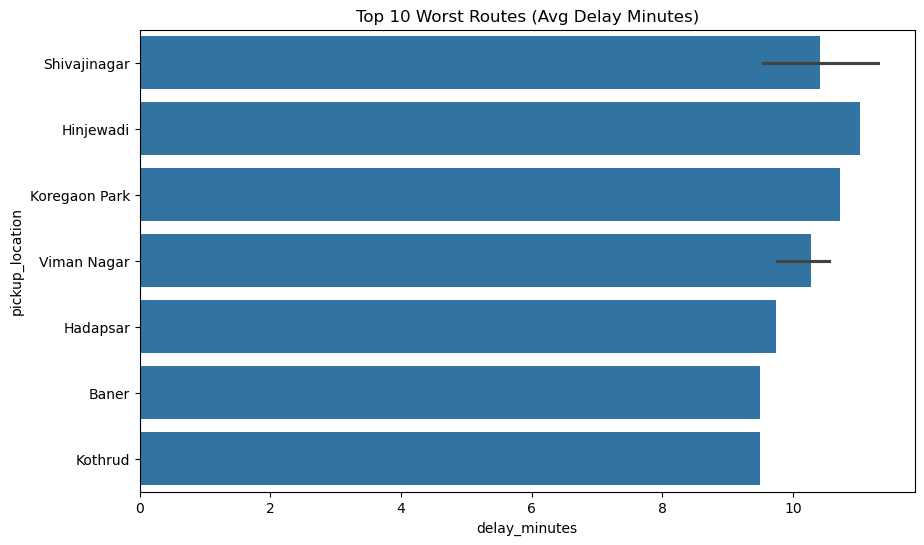

In [39]:
route_delay = df.groupby(["pickup_location","drop_location"])["delay_minutes"].mean().reset_index()
top_routes = route_delay.sort_values("delay_minutes", ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x="delay_minutes", y="pickup_location", data=top_routes)
plt.title("Top 10 Worst Routes (Avg Delay Minutes)")
plt.show()


In [63]:

# pickup_time ko random tarike se generate karna (July 2023 ke andar)
df['pickup_time'] = np.random.choice(
    pd.date_range("2023-07-01", "2023-07-31", freq="h"),
    size=len(df)
)

# Time-based features
df['pickup_day'] = df['pickup_time'].dt.day
df['pickup_hour'] = df['pickup_time'].dt.hour
df['pickup_weekday'] = df['pickup_time'].dt.weekday  # 0=Monday, 6=Sunday
df['is_weekend'] = df['pickup_weekday'] >= 5

print(df[['pickup_time','pickup_day','pickup_hour','pickup_weekday','is_weekend']].head())




          pickup_time  pickup_day  pickup_hour  pickup_weekday  is_weekend
0 2023-07-09 14:00:00           9           14               6        True
1 2023-07-06 17:00:00           6           17               3       False
2 2023-07-18 11:00:00          18           11               1       False
3 2023-07-23 22:00:00          23           22               6        True
4 2023-07-18 00:00:00          18            0               1       False


In [73]:


df['day_of_week'] = df['pickup_time'].dt.day_name()


df['hour'] = df['pickup_time'].dt.hour


df['time_period'] = pd.cut(
    df['hour'],
    bins=[0, 6, 10, 16, 21, 24],
    labels=['Late Night', 'Morning Peak', 'Afternoon', 'Evening Peak', 'Night'],
    right=False
)

print(df[['pickup_time','day_of_week','hour','time_period']].head())


          pickup_time day_of_week  hour   time_period
0 2023-07-06 23:00:00    Thursday    23         Night
1 2023-07-11 05:00:00     Tuesday     5    Late Night
2 2023-07-10 16:00:00      Monday    16  Evening Peak
3 2023-07-18 02:00:00     Tuesday     2    Late Night
4 2023-07-28 18:00:00      Friday    18  Evening Peak


In [75]:
weather_map = {
    "Clear": 0,
    "Cloudy": 1,
    "Rainy": 2,
    "Heavy Rain": 3,
    "Storm": 4
}
df['weather_severity'] = df['weather'].map(weather_map)


In [78]:
vehicle_map = {
    "Bike": 3,
    "Auto": 2,
    "Car": 1
}
df['vehicle_score'] = df['vehicle_type'].map(vehicle_map)


In [81]:
traffic_map = {
    "Low": 1,
    "Medium": 2,
    "High": 3,
    "Very High": 4
}
df['traffic_severity'] = df['traffic_level'].map(traffic_map)


In [84]:
df['route'] = df['pickup_location'] + " - " + df['drop_location']
route_freq = df['route'].value_counts().to_dict()
df['route_score'] = df['route'].map(route_freq)


In [86]:
print(df.head())


   ride_id pickup_location drop_location  distance_km  expected_time_min  \
0        1        Hadapsar        Pimpri        10.44                 31   
1        2         Kothrud         Wakad        10.61                 33   
2        3   Koregaon Park        Pimpri        13.32                 39   
3        4    Shivajinagar      Swargate        10.28                 28   
4        5     Viman Nagar         Wakad        20.63                 60   

   actual_time_min weather traffic_level vehicle_type  delay_minutes  ...  \
0               40   Clear          High         Auto              9  ...   
1               44   Rainy        Medium         Bike             11  ...   
2               39   Clear           Low         Auto              0  ...   
3               39   Rainy          High         Auto             11  ...   
4               70   Foggy        Medium         Auto             10  ...   

    time_period pickup_day pickup_hour  pickup_weekday is_weekend  \
0         N

In [88]:
# Weather Severity
weather_map = {"Clear": 0, "Cloudy": 1, "Rainy": 2, "Heavy Rain": 3, "Storm": 4}
df['weather_severity'] = df['weather'].map(weather_map)

# Traffic Severity
traffic_map = {"Low": 1, "Medium": 2, "High": 3, "Very High": 4}
df['traffic_severity'] = df['traffic_level'].map(traffic_map)

# Vehicle Score
vehicle_map = {"Bike": 3, "Auto": 2, "Car": 1}
df['vehicle_score'] = df['vehicle_type'].map(vehicle_map)


In [90]:
df['hour'] = df['pickup_time'].dt.hour
df['is_weekend'] = df['pickup_time'].dt.weekday >= 5


In [92]:
X = df[['distance_km', 'expected_time_min', 'weather_severity', 
        'traffic_severity', 'vehicle_score', 'route_score', 'hour', 'is_weekend']]
y = df['delayed'] 


In [94]:
from sklearn.model_selection 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [96]:
from sklearn.ensemble 
model = RandomForestClassifier()
model.fit(X_train, y_train)


RandomForestClassifier()

In [98]:
from sklearn.metrics 
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.89


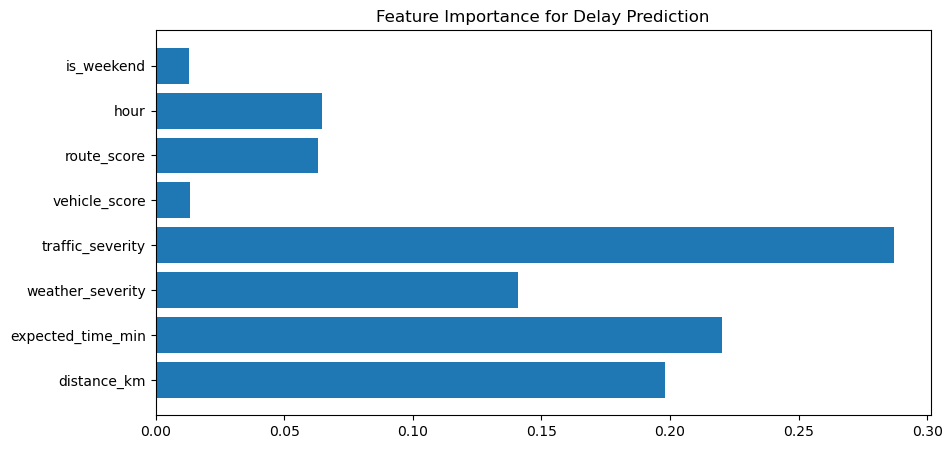

In [102]:
importances = model.feature_importances_
features = X.columns
plt.figure(figsize=(10,5))
plt.barh(features, importances)
plt.title("Feature Importance for Delay Prediction")
plt.show()

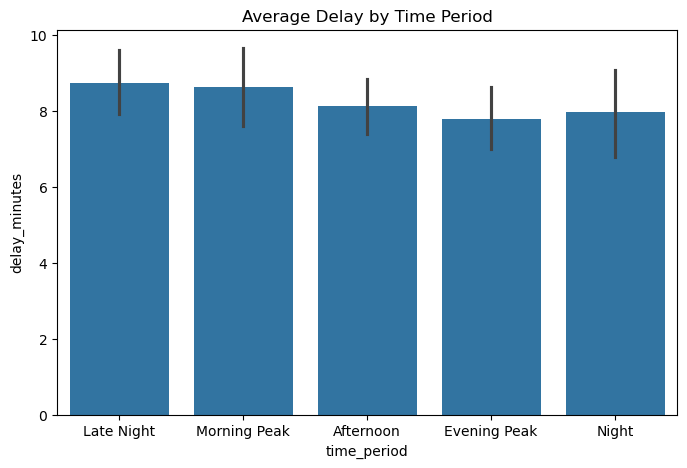

In [104]:
plt.figure(figsize=(8,5))
sns.barplot(x='time_period', y='delay_minutes', data=df, estimator='mean')
plt.title("Average Delay by Time Period")
plt.show()

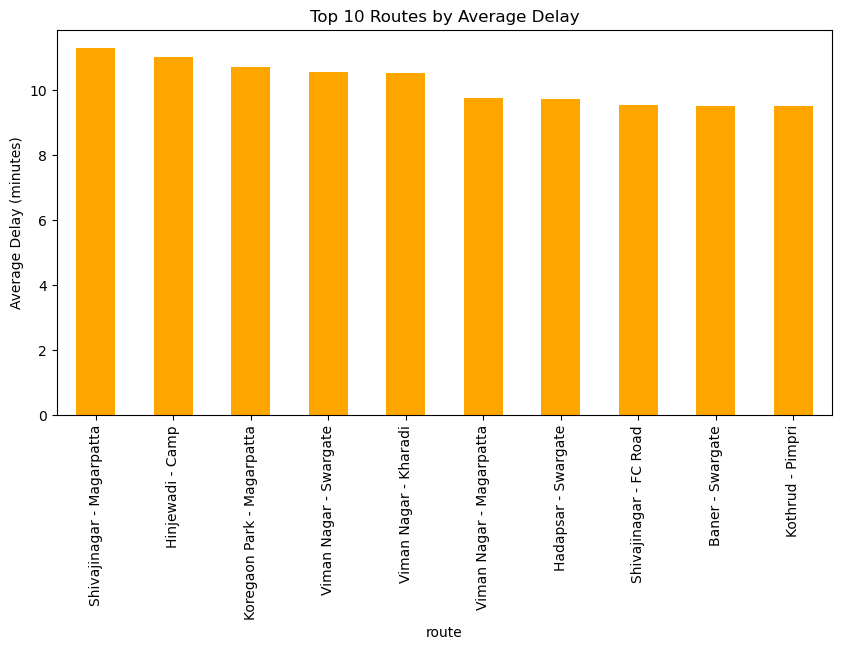

In [106]:
top_routes = df.groupby('route')['delay_minutes'].mean().sort_values(ascending=False).head(10)
top_routes.plot(kind='bar', figsize=(10,5), color='orange')
plt.title("Top 10 Routes by Average Delay")
plt.ylabel("Average Delay (minutes)")
plt.show()

In [110]:
sample = pd.DataFrame([[5, 15, 2, 3, 3, 10, 14, 0]],
                      columns=['distance_km', 'expected_time_min', 'weather_severity', 
                               'traffic_severity', 'vehicle_score', 'route_score', 'hour', 'is_weekend'])

prediction = model.predict(sample)[0]
print("Predicted Delay (Yes/No):", prediction)

Predicted Delay (Yes/No): 0


In [21]:



np.random.seed(42)
df['hour'] = np.random.randint(0, 24, size=len(df))

# Time period bins
df['time_period'] = pd.cut(
    df['hour'],
    bins=[0,6,10,16,21,24],
    labels=['Late Night', 'Morning Peak', 'Afternoon', 'Evening Peak', 'Night'],
    right=False
)

# Ab ye kaam karega
time_avg = df.groupby('time_period', observed=False)['delay_minutes'].mean()



In [4]:
import webbrowser
webbrowser.open("route_delay_heatmap.html")

True